In [1]:
from torch.utils.data import DataLoader,ConcatDataset
from lib.datasets import EpochedDataset
from sklearn.model_selection import train_test_split
from lib.ekyn import *
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torch
from lib.ekyn import *
from torch import nn
from torch.nn.functional import relu
import torch
from lib.env import *
import math
import json

In [2]:
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
train_idx,test_idx = train_idx[:1],test_idx[:1]
print(train_idx,test_idx)
trainloader = DataLoader(ConcatDataset([EpochedDataset(id=id,condition=condition,downsampled=True) for id in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(id=id,condition=condition,downsampled=True) for id in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrew/aurora/pt_ekyn'

In [6]:
model = Frodo(n_features=1000).cuda()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4,weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()
print(sum([p.flatten().size()[0] for p in list(model.parameters())]))

8187


In [19]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
model.train()
from tqdm import tqdm
from lib.utils import training_loop,development_loop
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device='cuda')
    trainlossi.append(loss)
    trainf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=devloader,criterion=criterion,device='cuda')
    devlossi.append(loss)
    devf1.append(f1)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,4),dpi=200)
    ax[0].plot(trainlossi)
    ax[0].plot(devlossi)
    ax[0].set_title(label='loss',fontweight='bold')
    ax[0].set_xlabel('Epoch')
    ax[1].plot(trainf1)
    ax[1].plot(devf1)
    ax[1].set_title(label='f1',fontweight='bold')
    ax[1].set_xlabel('Epoch')

    plt.savefig('loss.jpg')
    plt.close()

  2%|▏         | 16/1000 [00:24<25:23,  1.55s/it]


KeyboardInterrupt: 

100%|██████████| 34/34 [00:00<00:00, 85.17it/s]


              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67       943
         1.0       0.92      0.92      0.92      7976
         2.0       0.89      0.89      0.89      8361

    accuracy                           0.89     17280
   macro avg       0.83      0.82      0.83     17280
weighted avg       0.89      0.89      0.89     17280

0.27566322377499414


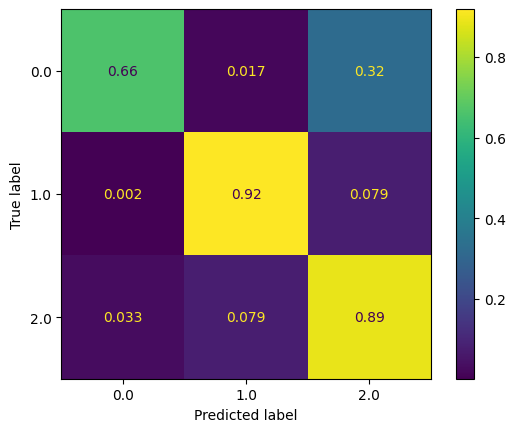

In [20]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)